A notebook to work through the generation of the PMFs through All-Atomistic MD simulations.

In [42]:
# Packages, recommend setting up and enviroment
import plotly.graph_objects as go
import os
import pandas as pd
import plotly.express as px
from itertools import cycle
import seaborn as sns
from matplotlib.pyplot import cm
import numpy as np
import matplotlib.pyplot as plt
color_map='gist_rainbow'
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import shutil
import scipy 
from scipy.interpolate import make_smoothing_spline

import io
import PIL.Image as Image

import matplotlib.lines as mlines
from matplotlib.backends.backend_pdf import PdfPages

# Amino Acid PMFS

This code should work through the process of generating the Potentials of Mean Force (PMF)s of different amino acids. In the `AAOriginalsimfiles` folder, there are folders containing the intial solvated boxes. These boxes contain one amino acid side chain solvated in TIP3P water. Energy minimisation has already been performed on these boxes. 

I highly recommend reading the tutorial on [Lysozyme](http://www.mdtutorials.com/gmx/lysozyme/01_pdb2gmx.html) to better familiarise yourself with gromacs general structure.

If you are interesting in creating these boxes yourself, all amino acids and their side chain analogues are present in the `PDBfiles` folder. With these `.pdb` files you can follow the above tutorial until energy minimisation. This is the starting point of the files in `AAOriginalsimfiles`.

The `.pdf` files were generated/created in CHARMM GUI [Ligand Modeller](https://charmm-gui.org/?doc=demo&id=ligand_reader&lesson=2) where you can input SMILES formula or draw the require molecule.

We will work through an example for ALA.

In [21]:
# Should just be in the downloaded file PPsimulation
wd = os.getcwd()
wd

'/Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles/ALA'

In [22]:
# Copy the simulation.sh file into the desired simulation files folder, we doing ALA
os.chdir("AAOriginalsimfiles")
src = "simulation.sh"
dst = "ALA/"
shutil.copy(src, dst)
os.chdir("ALA")


FileNotFoundError: [Errno 2] No such file or directory: 'AAOriginalsimfiles'

In [ ]:
# Check what is in the simulation.sh
open("simulation.sh").readlines()

['gmx grompp -f nvt.mdp -c system.gro -r system.gro -p system.top -n system.ndx -o nvt.tpr \n',
 'gmx mdrun -v -deffnm nvt \n',
 'gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p system.top -n system.ndx -o npt.tpr \n',
 'gmx mdrun -v -deffnm npt \n',
 'gmx grompp -f pro.mdp -c npt.gro -t npt.cpt -p system.top -n system.ndx -o md_50ns.tpr \n',
 'gmx mdrun -v -deffnm md_50ns \n',
 'gmx rdf -f md_50ns.xtc -n system.ndx -o rdf.xvg  \n']

The `simulation.sh` file sets up a NVT simulatio using `gmx grompp` and the `nvt.mdp` file. It then takes the `system.gro`, `system.top` and `system.ndx` files from the minimisation step as inputs, and outputs a `.tpr` file. The `.tpr` file is then used to run the simulation with `gmx mdrun`. The `-deffnm` defines the files names for your output. These outputs are then used as a starting point for the NVT simulation on line 3.

`.gro` files contain all your information about the box and particle locations inside it. `.tpr` contains information about running the simulation such as particle velocities and periodic boundary conditions, these are set in the `.mdp` files but the `.tpr` takes in all this information for running the simulations. `.cpt` is a continaution point flag, it allows us to continue simulations. Incredibly useful if you want to restart or extend a simulation. Examples of this are in the `AAPMFsimulations` folder, where the amino acids simualtions have been saved only for the last 100 ns. If you just want to perfomr PMF sims you can use the continue points and just extend thse trajectories. The `.ndx` file is and index file labelling the atoms. This can be generated at the begininning during energy minimisation, however if it ever goes missing you can create a new index using `gmx make_ndx` command.

The `.top` files contain information on the topology of our system, or how the atoms are connected. This is by far the most common cause of erros and frustartion in simulations. In our `system.top` files we have the topology spelled. However in other simulations, such as PFOS and the Melt, the topology is imported in. Ensure that everything is imported in and available in your files. An example is in the `Melt` folder, where the `.top` files import topologies from the `Melt/toppar` folder.

It is highly recommended you run these simulations on a HPC cluster, as they can get very long. Moreover if you cluster has gromacs set up and supports GPU usage you can easily use them by adding `-nb gpu` to the end of the `mdrun` lines.

For demonstration, we will run the `example.mdp` files present in the `ALA` folder. This is to show the outputs and how everything runs.

In [ ]:
# Move into heck that the gromacs is alive and well

!gmx --version

                     :-) GROMACS - gmx, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles
Command line:
  gmx --version

GROMACS version:     2025.1-Homebrew
Precision:           mixed
Memory model:        64 bit
MPI library:         thread_mpi
OpenMP support:      enabled (GMX_OPENMP_MAX_THREADS = 128)
GPU support:         disabled
SIMD instructions:   ARM_NEON_ASIMD
CPU FFT library:     fftw-3.3.10
GPU FFT library:     none
Multi-GPU FFT:       none
TNG support:         enabled
Hwloc support:       disabled
Tracing support:     disabled
C compiler:          /opt/homebrew/opt/gcc/bin/gcc-14
C compiler flags:    -fexcess-precision=fast -funroll-all-loops -Wno-missing-field-initializers -O3 -DNDEBUG
C++ compiler:        /opt/homebrew/opt/gcc/bin/g++-14
C++ compiler flags:  -fexcess-precision=fast -funroll-all

In [ ]:
# NVT first, the ! flag makes it run on your shell
!gmx grompp -f nvt_example.mdp -c system.gro -r system.gro -p system.top -n system.ndx -o nvt_example.tpr
!gmx mdrun -v -deffnm nvt_example

                 :-) GROMACS - gmx grompp, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles/ALA
Command line:
  gmx grompp -f nvt_example.mdp -c system.gro -r system.gro -p system.top -n system.ndx -o nvt_example.tpr

Ignoring obsolete mdp entry 'rlistlong'
Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Setting the LD random seed to -591399077

Generated 1707 of the 1711 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 946 of the 1711 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'ALA'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'PP'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'TIP3'

turning H bonds into constraints...

E

In [ ]:
# Next we do NPT and actual production run, notice the inputs are the outputs of last
# Note; this will likely blow up due to links error as we are not equilibrating for long enough.
!gmx grompp -f npt_example.mdp -c nvt_example.gro -r nvt_example.gro -t nvt_example.cpt -p system.top -n system.ndx -o npt_example.tpr
!gmx mdrun -v -deffnm npt_example
!gmx grompp -f pro.mdp -c npt_example.gro -t npt_example.cpt -p system.top -n system.ndx -o md_example.tpr
!gmx mdrun -v -deffnm md_example


                 :-) GROMACS - gmx grompp, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles/ALA
Command line:
  gmx grompp -f npt_example.mdp -c nvt_example.gro -r nvt_example.gro -t nvt_example.cpt -p system.top -n system.ndx -o npt_example.tpr

Ignoring obsolete mdp entry 'rlistlong'
Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Setting the LD random seed to -233846021

Generated 1707 of the 1711 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 946 of the 1711 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'ALA'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'PP'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'TIP3'

turning H

Now we have finished our production run we have data, results. We can now move on to calculating the PMFs.

The PMF for pairwise interaction can be recovered from the radial distribution functions (RDF) $g(r)$: 
$$W(r) = -k_BT\ln [g(r)]$$


In [28]:
# Get rdf using gmx rdf command, remeber to change from example
# Run this for a second to get the output.
!gmx rdf -f md_example.xtc -n system.ndx -o rdf.xvg 


                   :-) GROMACS - gmx rdf, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles/ALA
Command line:
  gmx rdf -f md_example.xtc -n system.ndx -o rdf.xvg

Available static index groups:
 Group  0 "System" (45536 atoms)
 Group  1 "Protein" (5 atoms)
 Group  2 "Protein-H" (1 atoms)
 Group  3 "C-alpha" (0 atoms)
 Group  4 "Backbone" (0 atoms)
 Group  5 "MainChain" (0 atoms)
 Group  6 "MainChain+Cb" (1 atoms)
 Group  7 "MainChain+H" (0 atoms)
 Group  8 "SideChain" (5 atoms)
 Group  9 "SideChain-H" (1 atoms)
 Group 10 "Prot-Masses" (5 atoms)
 Group 11 "non-Protein" (45531 atoms)
 Group 12 "Other" (45531 atoms)
 Group 13 "PROR" (20 atoms)
 Group 14 "PROS" (18 atoms)
 Group 15 "TIP3" (45453 atoms)
 Group 16 "SOD" (20 atoms)
 Group 17 "CLA" (20 atoms)
Specify a selection for option 'ref'
(Reference selectio

OSError: [Errno 5] Input/output error

For Gromacs we must choose a refrence and selection `-ref`, `-sel`. We want our entire Polypropylene to be the refrence and the amino acid to be the selection. From the output above the amino acid is the Protein group, while the PROR and PROS are the plastic. We must combine these to to get a new index file so we can get the rdf.

In [ ]:
# PROR is group 13, PROS is group 14, make combined group using gmx make_ndx
# Due to lincs blowing up we will use the preran.gro and xtc, use your actual output
!echo "13 | 14\nq" | gmx make_ndx -f md_preran.gro -n system.ndx -o rdf.ndx



                :-) GROMACS - gmx make_ndx, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles/ALA
Command line:
  gmx make_ndx -f md_preran.gro -n system.ndx -o rdf.ndx


Reading structure file
Going to read 1 old index file(s)

  0 System              : 45536 atoms
  1 Protein             :     5 atoms
  2 Protein-H           :     1 atoms
  3 C-alpha             :     0 atoms
  4 Backbone            :     0 atoms
  5 MainChain           :     0 atoms
  6 MainChain+Cb        :     1 atoms
  7 MainChain+H         :     0 atoms
  8 SideChain           :     5 atoms
  9 SideChain-H         :     1 atoms
 10 Prot-Masses         :     5 atoms
 11 non-Protein         : 45531 atoms
 12 Other               : 45531 atoms
 13 PROR                :    20 atoms
 14 PROS                :    18 atoms
 15 TIP3            

In [38]:
!echo "PROR_PROS\n Protein\n" | gmx rdf -f md_preran.xtc -n rdf.ndx -o rdf.xvg 

                   :-) GROMACS - gmx rdf, 2025.1-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2025.1/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2025.1
Working dir:  /Users/brianmaloney/Desktop/MastersProject/githubfiles/AAOriginalsimfiles/ALA
Command line:
  gmx rdf -f md_preran.xtc -n rdf.ndx -o rdf.xvg

Last frame        100 time 300000.000   
Analyzed 101 frames, last time 300000.000

Back Off! I just backed up rdf.xvg to ./#rdf.xvg.1#

GROMACS reminds you: "Not everyone is capable of madness; and of those lucky enough to be capable, not many have the courage for it." (August Strindberg)



Now that we have our rdfs, we can plot them and invert them. Included in the `AAPMFsimulations` folder are two notebooks for plotting. They should hopefully work. For these folders the radius of gyration was also calculate using `gmx gyrate`. This was done as we need a radius to create the Polyproyplene nanoparticle later.

In [39]:
# Function to read .xvg files
def read_xvg(file_name):
    # Initialize lists to store the data
    data = []
    with open(file_name, 'r') as f:
        for line in f:
            # Skip comment lines starting with '#'
            if line.startswith(('#', '@')):
                continue
            # Read numeric data
            columns = line.split()
            data.append([float(i) for i in columns])
    
    # Convert the list into a NumPy array for easy handling
    return np.array(data)

/var/folders/91/m5nbnsy55w9cpmpb7kvf0d8h0000gn/T/ipykernel_81340/3758331764.py:15: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(RDF)


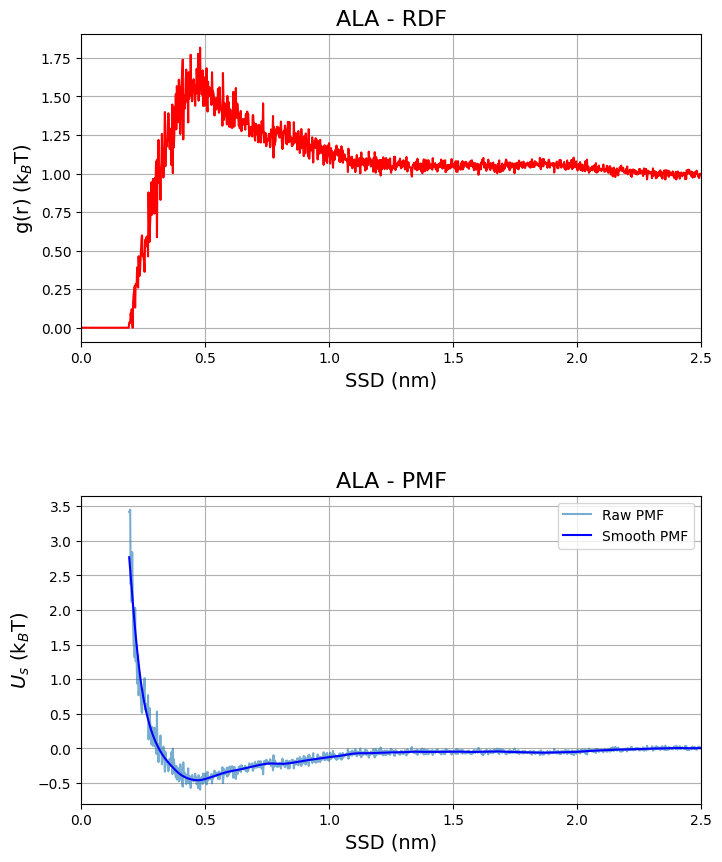

In [ ]:
# This will give nonsense answers for the example. Use the preran results
# All rdf results are in the original files
file_name = "preran_rdf.xvg"
data = read_xvg(file_name)
r = data[:, 0]  # Time data (first column)
RDF = data[:, 1]  # Data of interest (second column)

#Normalise
long_range = RDF[(r > 2) & (r < 3)]
RDF = RDF/np.mean(long_range)

SSD = []
PMF = []


pmf = -np.log(RDF)

for i in range(len(r)):
    if pmf[i] > -300 and pmf[i] < 300:
        SSD.append(r[i])
        PMF.append(pmf[i])

spl = make_smoothing_spline(SSD, PMF, lam=0.0001)
saveas = "ALA.dat"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
fig.subplots_adjust(hspace=0.5)
# RDF plot
ax1.plot(r, RDF, color='r')
ax1.set_ylabel(r"g(r) (k$_{B}$T)", fontsize=14)
ax1.set_xlabel('SSD (nm)', fontsize=14)
ax1.set_xlim(0, 2.5)
ax1.set_title('ALA - RDF', fontsize=16)
ax1.grid(True)

# PMF plot
ax2.plot(SSD, PMF, label='Raw PMF', alpha=0.6)
ax2.plot(SSD, spl(SSD), color='b', label='Smooth PMF')
ax2.set_xlabel('SSD (nm)', fontsize=14)
ax2.set_ylabel(r"$U_{s}$ (k$_{B}$T)", fontsize=14)
ax2.set_xlim(0, 2.5)
ax2.set_title('ALA - PMF', fontsize=16)
ax2.grid(True)
ax2.legend()

The results of the PMFs are now saved as `.dat` files. These files will be used as the inputs for the CornanKMC and Protein Adsorption calculations.

This bring us to the end of the RDF-PMF calculation. 